In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random
from datetime import datetime

import geopandas as gpd
import googlemaps
import keyring
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import polyline
import seaborn as sns
from IPython.display import Markdown
from pyspark.sql import SparkSession
from pyspark.sql import types as T
from shapely.geometry import Point, LineString

palette = sns.color_palette("colorblind", 20)


def to_geo(df, x_field='longitude', y_field='latitude'):
    geometry = [Point(xy) for xy in zip(df[x_field], df[y_field])]
    return gpd.GeoDataFrame(df, geometry=geometry)


spark = (
    SparkSession.builder
        .master("local")
        .appName("TFL Notebook")
        .config('spark.executor.memory', '8G')
        .config('spark.driver.memory', '16G')
        .config('spark.driver.maxResultSize', '10G')
        .config("spark.sql.crossJoin.enabled", "true")
        .getOrCreate()
)

BIKE_POINTS_FILE = "../data/bike-points.csv"

schema = T.StructType([
    T.StructField("idx",       T.IntegerType(), False),
    T.StructField("id",        T.IntegerType(), False),
    T.StructField("name",      T.StringType(),  False),
    T.StructField("latitude",  T.DoubleType(),  False),
    T.StructField("longitude", T.DoubleType(),  False),
    T.StructField("osgb_x",    T.DoubleType(),  False),
    T.StructField("osgb_y",    T.DoubleType(),  False),
    T.StructField("numdocks",  T.LongType(),    False),
    T.StructField("num_bikes", T.LongType(),    False),
    T.StructField("num_empty", T.LongType(),    False)
])
bike_points = spark.read.csv(BIKE_POINTS_FILE, schema=schema, header='true', mode="PERMISSIVE")
bike_points.createOrReplaceTempView("bike_points")

trips = spark.read.parquet("../data/parquet_trip")
trips.createOrReplaceTempView("trips")

df = spark.sql("""
    select (sum(duration) / 60) as duration, count(1) as trip_count, bike_id, start_year, start_month, start_day from trips
    group by bike_id, start_year, start_month, start_day
    order by trip_count desc
""")

df.createOrReplaceTempView("busy_bikes")

top_bikes = df.limit(20).toPandas()

top_bikes

,duration,trip_count,bike_id,start_year,start_month,start_day
0,334.00,28,11706,2017,9,1
1,609.00,27,2768,2015,7,9
2,496.00,25,12324,2017,6,21
3,428.00,24,6525,2015,8,6
4,635.00,24,1295,2015,8,7
5,486.00,24,2177,2015,7,9
6,442.00,24,7200,2016,7,30
7,523.00,24,10996,2015,7,9
8,545.00,23,316,2015,8,6
9,568.00,23,12022,2018,6,29


### Trips per bike per day

Difficult to tell how many bikes didn't move in a day, since we obviously don't have trips recorded!  Can approximate from total number of unique bikes for the month or something like that...?

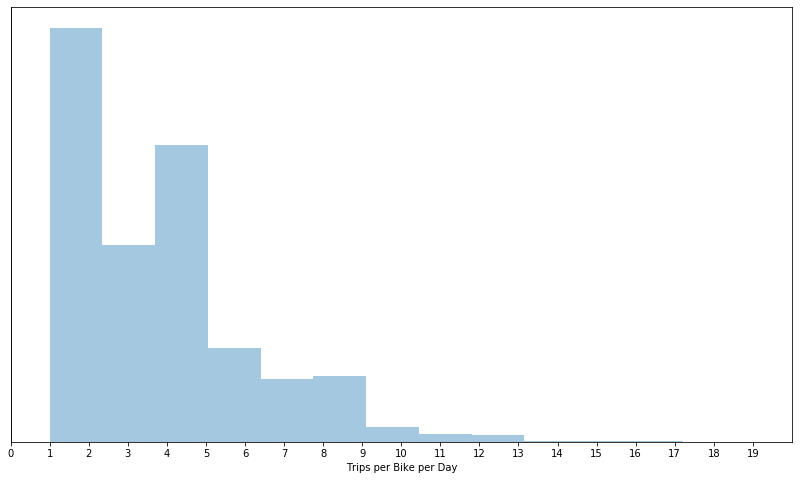

In [8]:
plt.subplots(figsize=(14, 8))

all_bikes = df.toPandas()

ax = sns.distplot(all_bikes['trip_count'], label='Trips per bike per day', bins=20, kde=False)

ax.yaxis.set_visible(False)
ax.set_xlim([0, 20])
plt.xticks(np.arange(0, 20, 1))

plt.title("", fontsize=18)
plt.axvline(0, color='black')
plt.xlabel("Trips per Bike per Day")
plt.ylabel("")
plt.show()

### Select Interesting Bike:

In [4]:
my_bike = random.choice(top_bikes.to_dict(orient='records'))

my_bike

{'bike_id': 316,
 'duration': 545.0,
 'start_day': 6,
 'start_month': 8,
 'start_year': 2015,
 'trip_count': 23}

In [5]:

bike_id = my_bike['bike_id']
year = my_bike['start_year']
month = my_bike['start_month']
day = my_bike['start_day']

journeys = spark.sql("""
    select 
     t.start_ts, 
     t.start_station_name, 
     t.end_ts, 
     t.end_station_name, 
     t.duration, 
     a.latitude as start_lat, 
     a.longitude as start_lon, 
     b.latitude as end_lat, 
     b.longitude as end_lon
    from trips t
    join bike_points a on (t.start_station_id = a.id)
    join bike_points b on (t.end_station_id = b.id)
    where bike_id = {0} 
      and start_year = {1} 
      and start_month = {2} 
      and start_day = {3}
    order by start_ts asc
""".format(bike_id, year, month, day)).toPandas()

journeys

,start_ts,start_station_name,end_ts,end_station_name,duration,start_lat,start_lon,end_lat,end_lon
0,2015-08-06 07:47:00,"Baylis Road, Waterloo",2015-08-06 08:06:00,"Brunswick Square, Bloomsbury",1140,51.501444,-0.110699,51.523951,-0.122502
1,2015-08-06 08:12:00,"Brunswick Square, Bloomsbury",2015-08-06 08:32:00,"Park Road (Baker Street), The Regent's Park",1200,51.523951,-0.122502,51.524517,-0.158963
2,2015-08-06 08:35:00,"Park Road (Baker Street), The Regent's Park",2015-08-06 08:59:00,"Doric Way , Somers Town",1440,51.524517,-0.158963,51.528833,-0.132250
3,2015-08-06 09:11:00,"Doric Way , Somers Town",2015-08-06 09:46:00,"Kennington Lane Rail Bridge, Vauxhall",2100,51.528833,-0.132250,51.486343,-0.122492
4,2015-08-06 10:01:00,"Kennington Lane Rail Bridge, Vauxhall",2015-08-06 10:05:00,"Fire Brigade Pier, Vauxhall",240,51.486343,-0.122492,51.493699,-0.121394
5,2015-08-06 10:12:00,"Fire Brigade Pier, Vauxhall",2015-08-06 10:44:00,"Boston Place, Marylebone",1920,51.493699,-0.121394,51.522511,-0.162298
6,2015-08-06 10:48:00,"Boston Place, Marylebone",2015-08-06 11:03:00,"Winsland Street, Paddington",900,51.522511,-0.162298,51.516780,-0.175488
7,2015-08-06 11:09:00,"Winsland Street, Paddington",2015-08-06 12:20:00,"Chelsea Green, Chelsea",4260,51.516780,-0.175488,51.490664,-0.166485
8,2015-08-06 13:48:00,"Chelsea Green, Chelsea",2015-08-06 14:19:00,"Pall Mall East, West End",1860,51.490664,-0.166485,51.507770,-0.130699
9,2015-08-06 15:20:00,"Pall Mall East, West End",2015-08-06 15:56:00,"South Kensington Station, South Kensington",2160,51.507770,-0.130699,51.494412,-0.173881


In [6]:
gmaps = googlemaps.Client(key=keyring.get_password('logicalgenetics', 'google'))

route_data = []

for index, row in journeys.iterrows():
    p1 = (row['start_lon'], row['start_lat'])
    p2 = (row['end_lon'], row['end_lat'])

    directions_result = gmaps.directions("{1}, {0}".format(*p1),
                                         "{1}, {0}".format(*p2),
                                         mode="bicycling",
                                         departure_time=datetime.now())

    encoded = directions_result[0]['overview_polyline']['points']
    points = [(lat, lon) for (lon, lat) in polyline.decode(encoded)]
    
    if len(points) > 1:
        route_data.append(LineString(points))
    else:
        route_data.append(LineString([p1, p1])) # Zero length line
        

In [7]:
fig,ax=plt.subplots(figsize=(14,10))

palette = sns.color_palette("colorblind", journeys.count()[0])

starts = to_geo(journeys[['start_lon', 'start_lat']], x_field='start_lon', y_field='start_lat')
ends = to_geo(journeys[['end_lon', 'end_lat']], x_field='end_lon', y_field='end_lat')

routes = gpd.GeoDataFrame(pd.DataFrame(route_data, columns=['geometry']))
routes.plot(ax=ax, color=palette, linewidth=4.0)

ends.plot(ax=ax, markersize=100, marker='s', color=palette)
starts.plot(ax=ax, markersize=75, marker='o', color=palette)
mplleaflet.display(fig=fig, crs=starts.crs, tiles='cartodb_positron')